In [ ]:
storage_key = dbutils.secrets.get(scope="your-secret-scope-name", key="shushilacckey")


In [ ]:
# Set up storage configuration
storage_name = "shushilgstorage"
spark.conf.set("fs.azure.account.key.shushilgstorage.blob.core.windows.net", storage_key)
spark.conf.set(f"fs.azure.account.key.{storage_name}.blob.core.windows.net", storage_key)


In [ ]:
storage_path="wasbs://deltadataset@shushilgstorage.blob.core.windows.net/spotify_cleaned"

In [ ]:

# Load Delta file
spotify_df = spark.read.format("delta").load(storage_path)

# Display sample rows
spotify_df.show(5)


StatementMeta(shushil1, 0, 7, Finished, Available, Finished)

+--------------------+----+----------+------+--------------------+---------+------+-------------+-------+----+-------+------+------------+------------+
|               title|rank|      date|artist|                 url|   region| chart|        trend|streams|year|  month|   day|artist_fname|artist_lname|
+--------------------+----+----------+------+--------------------+---------+------+-------------+-------+----+-------+------+------------+------------+
|       baila conmigo|  77|2017-01-01|  null|https://open.spot...|argentina|top200|      move_up|  30623|2017|january|sunday|        juan|        magn|
|can't stop the fe...|  12|2017-01-01|  null|https://open.spot...|  belgium|top200|    move_down|  11819|2017|january|sunday|      justin|  timberlake|
|            tchikita| 150|2017-01-01|  null|https://open.spot...|  belgium|top200|      move_up|   2570|2017|january|sunday|         jul|            |
|   take me to church| 174|2017-01-01|  null|https://open.spot...|  belgium|top200|     

Trend Analysis
Monthly and Yearly Stream Trends:

In [ ]:
from pyspark.sql.functions import sum
spotify_df.groupBy("year", "month").agg(sum("streams").alias("TotalStreams")) \
.orderBy("year", "month").show()


StatementMeta(shushil1, 0, 15, Finished, Available, Finished)

+----+---------+------------+
|year|    month|TotalStreams|
+----+---------+------------+
|2017|    april| 14596390230|
|2017|   august| 14620464664|
|2017| december| 16341683149|
|2017| february| 12279457316|
|2017|  january| 12656756211|
|2017|     july| 14826129401|
|2017|     june| 14237992410|
|2017|    march| 15777232509|
|2017|      may| 14518560059|
|2017| november| 14677099056|
|2017|  october| 15073216971|
|2017|september| 14833417018|
|2018|    april| 16977238683|
|2018|   august| 17424927784|
|2018| december| 19556861882|
|2018| february| 14763150551|
|2018|  january| 15703181972|
|2018|     july| 17922445394|
|2018|     june| 17135879193|
|2018|    march| 16523675245|
+----+---------+------------+
only showing top 20 rows



Day of the Week Analysis:

In [ ]:
spotify_df.groupBy("day").avg("streams").orderBy("day").show()


StatementMeta(shushil1, 0, 16, Finished, Available, Finished)

+---------+------------------+
|      day|      avg(streams)|
+---------+------------------+
|   friday| 59757.51762737565|
|   monday| 53700.51945033045|
| saturday|57793.601360058594|
|   sunday|  51942.5521399938|
| thursday|54794.709193097435|
|  tuesday| 54315.94044390773|
|wednesday| 54488.35403167535|
+---------+------------------+



Regional Insights
Top Songs by Region:

In [ ]:
from pyspark.sql.functions import concat, col, lit

# Create full_name column
full_namedf = spotify_df.withColumn("artist_name", concat(col("artist_fname"), lit(" "), col("artist_lname")))

# Group by region and artist_name, sum streams, and order results
result = full_namedf.groupBy("region", "artist_name") \
    .agg({"streams": "sum"}) \
    .withColumnRenamed("sum(streams)","TotalStreams") \
    .orderBy("region", col("TotalStreams").desc())

# Show top 10 results
result.show(10, truncate=False)

StatementMeta(shushil1, 0, 25, Finished, Available, Finished)

+---------+---------------+------------+
|region   |artist_name    |TotalStreams|
+---------+---------------+------------+
|argentina|bad bunny      |631804836   |
|argentina|j balvin       |563868233   |
|argentina|rauw alejandro |469222553   |
|argentina|paulo londra   |395869079   |
|argentina|sebastian yatra|388647600   |
|argentina|maluma         |360531136   |
|argentina|karol g        |335783711   |
|argentina|maria becerra  |301915485   |
|argentina|anuel aa       |299688235   |
|argentina|daddy yankee   |298160513   |
+---------+---------------+------------+
only showing top 10 rows



Song Longevity:

In [ ]:
from pyspark.sql.functions import *

result = spotify_df.groupBy("title").agg(
    min("date").alias("entry_date"),
    max("date").alias("last_date"),
    count("date").alias("days_on_chart")
).orderBy("days_on_chart", ascending=False)

result.show(10, truncate=False)

StatementMeta(shushil1, 0, 28, Finished, Available, Finished)

+------------------------------------------+----------+----------+-------------+
|title                                     |entry_date|last_date |days_on_chart|
+------------------------------------------+----------+----------+-------------+
|shape of you                              |2017-01-06|2021-12-31|65276        |
|believer                                  |2017-01-01|2021-12-31|58314        |
|happier                                   |2017-03-02|2021-12-31|54584        |
|perfect                                   |2017-02-14|2021-12-31|52736        |
|someone you loved                         |2018-11-09|2021-12-31|50975        |
|blinding lights                           |2019-11-29|2021-12-31|47747        |
|dance monkey                              |2019-05-13|2021-12-31|43369        |
|shallow                                   |2018-09-27|2021-12-30|41312        |
|don't start now                           |2019-11-01|2021-12-31|40240        |
|sunflower  spiderman: into 

In [ ]:
spotify_df.select('trend').distinct().show()

StatementMeta(shushil1, 0, 31, Finished, Available, Finished)

+-------------+
|        trend|
+-------------+
|    move_down|
|    new_entry|
|      move_up|
|same_position|
+-------------+



Trend-Based Analysis
A. Distribution of Trends
Analyze the distribution of songs by their trend categories to understand how often songs move up, down, or retain their positions.

StatementMeta(shushil1, 0, 40, Finished, Available, Finished)

+-------------+-------+
|        trend|  count|
+-------------+-------+
|    new_entry|1180679|
|same_position|2331159|
|      move_up|7831595|
|    move_down|8972990|
+-------------+-------+



(array([       0.,  2000000.,  4000000.,  6000000.,  8000000., 10000000.]),
 [Text(0.0, 0, '0'),
  Text(2000000.0, 0, '2'),
  Text(4000000.0, 0, '4'),
  Text(6000000.0, 0, '6'),
  Text(8000000.0, 0, '8'),
  Text(10000000.0, 0, '10')])

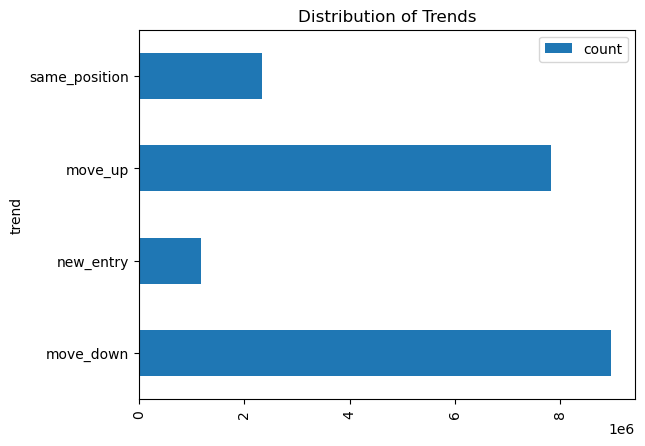

In [ ]:
import matplotlib.pyplot as plt
spotify_df.groupBy("trend").count().orderBy("count", ascending=True).show()

# Visualization (if using Python and Matplotlib/Seaborn)
trend_distribution = spotify_df.groupBy("trend").count().toPandas()
trend_distribution.plot(kind="barh", x="trend", y="count", title="Distribution of Trends")

plt.xticks(rotation=90)

Impact of Trends on Streams
Calculate the average streams for each trend to see how position changes influence song popularity.

StatementMeta(shushil1, 0, 42, Finished, Available, Finished)

+-------------+------------------+
|        trend|      avg(streams)|
+-------------+------------------+
|same_position|105190.12676441204|
|      move_up| 50967.83200676235|
|    move_down| 48754.42217231937|
|    new_entry| 34743.80964428096|
+-------------+------------------+



(array([0, 1, 2, 3]),
 [Text(0, 0, 'move_down'),
  Text(1, 0, 'new_entry'),
  Text(2, 0, 'move_up'),
  Text(3, 0, 'same_position')])

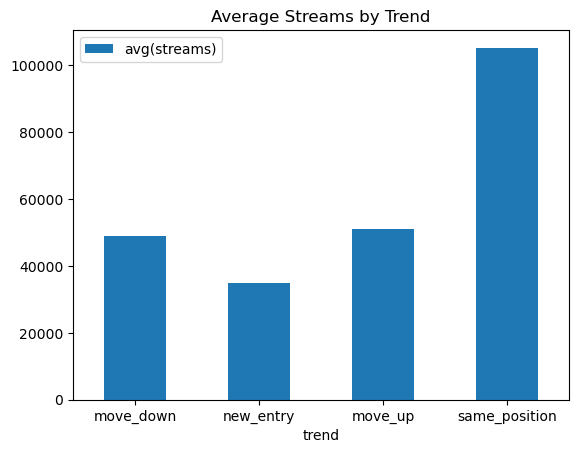

In [ ]:
spotify_df.groupBy("trend").avg("streams").orderBy("avg(streams)", ascending=False).show()

# Visualization (Bar Chart)
trend_streams = spotify_df.groupBy("trend").avg("streams").toPandas()
trend_streams.plot(kind="bar", x="trend", y="avg(streams)", title="Average Streams by Trend")
plt.xticks(rotation=0)

2. Trend and Rank Movement Analysis
A. Average Rank by Trend
Calculate the average rank for each trend category to see how trends correlate with position changes.

StatementMeta(shushil1, 0, 44, Finished, Available, Finished)

+-------------+------------------+
|        trend|         avg(rank)|
+-------------+------------------+
|same_position| 45.51131218419679|
|      move_up| 95.79318887148787|
|    move_down|103.43369679449103|
|    new_entry|155.66577028980782|
+-------------+------------------+



(array([0, 1, 2, 3]),
 [Text(0, 0, 'move_down'),
  Text(1, 0, 'new_entry'),
  Text(2, 0, 'move_up'),
  Text(3, 0, 'same_position')])

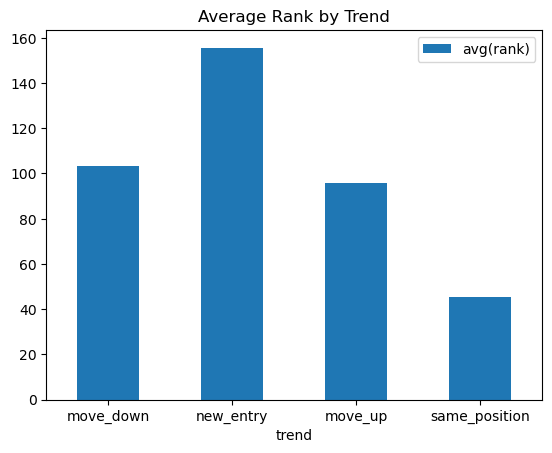

In [ ]:
spotify_df.groupBy("trend").avg("rank").orderBy("avg(rank)").show()

# Visualization (Bar Chart)
trend_rank = spotify_df.groupBy("trend").avg("rank").toPandas()
trend_rank.plot(kind="bar", x="trend", y="avg(rank)", title="Average Rank by Trend")
plt.xticks(rotation=0)


In [ ]:
spotify_df.groupBy("region", "trend").count().orderBy("region", "trend").show()


StatementMeta(shushil1, 0, 39, Finished, Available, Finished)

+---------+-------------+------+
|   region|        trend| count|
+---------+-------------+------+
|argentina|    move_down|156580|
|argentina|      move_up|135693|
|argentina|    new_entry| 18299|
|argentina|same_position| 53725|
|australia|    move_down|157488|
|australia|      move_up|139302|
|australia|    new_entry| 19575|
|australia|same_position| 45814|
|  austria|    move_down|164852|
|  austria|      move_up|141899|
|  austria|    new_entry| 24731|
|  austria|same_position| 32328|
|  belgium|    move_down|158647|
|  belgium|      move_up|141121|
|  belgium|    new_entry| 25408|
|  belgium|same_position| 33195|
|  bolivia|    move_down|134212|
|  bolivia|      move_up|119178|
|  bolivia|    new_entry| 16295|
|  bolivia|same_position| 44160|
+---------+-------------+------+
only showing top 20 rows

